In [1]:
!pip freeze > requirements-working.txt

# Importing Libraries

In [2]:
import numpy as np
import os
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from absl import logging
import shutil

from tflite_model_maker import object_detector
from tflite_model_maker.object_detector import DataLoader
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec

C:\Users\fahad\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\fahad\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter

# Setting Up for TensorFlow 2.0

In [3]:
assert tf.__version__.startswith('2')

# Suppress TensorFlow and absl logs for cleaner output
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

# Dataset Preprocessing and Augmentation

### Directory paths

In [4]:
base_dir = r'Object-detection-dataset'
train_dir = 'Object-detection-dataset/train'
valid_dir = 'Object-detection-dataset/valid'

### Extracting Label Map

In [5]:
# Extract labels from XML files
def extract_labels(directory):
    labels = set()
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            tree = ET.parse(os.path.join(directory, filename))
            root = tree.getroot()
            for obj in root.findall('object'):
                labels.add(obj.find('name').text)
    return labels

# Extract and merge all labels
train_labels = extract_labels(train_dir)
valid_labels = extract_labels(valid_dir)
all_labels = sorted(train_labels.union(valid_labels))

# Convert to the required label_map
label_map = {i + 1: name for i, name in enumerate(all_labels)}

# Display the labels
print("Labels used in your annotations:")
for label in all_labels:
    print(label)

Labels used in your annotations:
Tom Tom
aeroplane
apple
backpack
banana
baseball bat
baseball glove
bear
bed
bench
bicycle
bin
bird
boat
book
bottle
bowl
broccoli
bus
cake
car
cat
cell phone
chair
clock
cng
cow
cup
diningtable
dog
donut
door
elephant
fire hydrant
fork
frisbee
giraffe
glass partition
handbag
horse
hot dog
keyboard
kite
knife
laptop
microwave
motorbike
motorcycle
mouse
orange
oven
parking meter
person
pillar
pizza
pottedplant
railing
refrigerator
remote
rickshaw
sandwich
scissors
sheep
shelf
sink
skateboard
skis
snowboard
sofa
spoon
sports ball
stair
stop sign
suitcase
surfboard
table
teddy bear
tempu
tennis racket
tie
toilet
traffic light
train
tree
truck
tvmonitor
umbrella
van
vase
wine glass
zebra


### Data Augmentation

In [6]:
def augment_image(image, bbox):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, bbox

### Apply and Save Augmented Images

In [7]:
aug_dir = os.path.join(base_dir, 'train_augmented')
os.makedirs(aug_dir, exist_ok=True)

for file in os.listdir(train_dir):
    if file.endswith('.jpg') or file.endswith('.png'):
        base_name = os.path.splitext(file)[0]
        img_path = os.path.join(train_dir, file)
        xml_path = os.path.join(train_dir, base_name + '.xml')

        if not os.path.exists(xml_path):
            continue  # Skip if annotation missing

        # Load and augment image
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels = 3)
        image = tf.image.resize(image, (256, 256))
        image = tf.cast(image, tf.uint8)

        aug_image, _ = augment_image(image, None)
        aug_image = tf.image.encode_jpeg(tf.cast(aug_image, tf.uint8))

        # Save augmented image
        aug_img_name = base_name + '_aug.jpg'
        aug_img_path = os.path.join(aug_dir, aug_img_name)
        tf.io.write_file(aug_img_path, aug_image)

        # Copy original XML with new name
        aug_xml_name = base_name + '_aug.xml'
        shutil.copy(xml_path, os.path.join(aug_dir, aug_xml_name))

### Merge Original and Augmented Training Data

In [8]:
train_combined_dir = os.path.join(base_dir, 'train_combined')
os.makedirs(train_combined_dir, exist_ok = True)

for src_dir in [train_dir, aug_dir]:
    for f in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_combined_dir, f))

### Load Dataset with Augmented Data

In [9]:
train_data = object_detector.DataLoader.from_pascal_voc(
    train_combined_dir,
    train_combined_dir,
    label_map
)

val_data = object_detector.DataLoader.from_pascal_voc(
    valid_dir,
    valid_dir,
    label_map
)

# Initialize EfficientDet-Lite2 Pretrained Model

In [10]:
spec = model_spec.get('efficientdet_lite2')

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

spec.optimizer = Adam(learning_rate=lr_schedule)

# Model Training

### Training Configuration

In [11]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCH_SIZE = 50

### Training

In [12]:
model = object_detector.create(
    train_data,
    model_spec=spec,
    batch_size=BATCH_SIZE,
    train_whole_model=False,  # Freeze backbone, train only detection head
    validation_data=val_data,
    epochs=EPOCH_SIZE,
    do_train=True,
)

Epoch 1/50
102/102 [==============================] - 370s 3s/step - det_loss: 1.9325 - cls_loss: 1.3996 - box_loss: 0.0107 - reg_l2_loss: 0.0208 - loss: 1.9534 - learning_rate: 0.0090 - gradient_norm: 0.6764 - val_det_loss: 1.5757 - val_cls_loss: 1.2321 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0208 - val_loss: 1.5966
Epoch 2/50
102/102 [==============================] - 351s 3s/step - det_loss: 1.5394 - cls_loss: 1.1926 - box_loss: 0.0069 - reg_l2_loss: 0.0209 - loss: 1.5603 - learning_rate: 0.0100 - gradient_norm: 0.8287 - val_det_loss: 1.4040 - val_cls_loss: 1.1106 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0209 - val_loss: 1.4248
Epoch 3/50
102/102 [==============================] - 357s 4s/step - det_loss: 1.4159 - cls_loss: 1.1051 - box_loss: 0.0062 - reg_l2_loss: 0.0209 - loss: 1.4368 - learning_rate: 0.0099 - gradient_norm: 0.9000 - val_det_loss: 1.3081 - val_cls_loss: 1.0324 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0209 - val_loss: 1.3290
Epoch 4/50
102/102 [===========

# Model Summary and Plot

In [13]:
model.model.summary()
plot_model(model.model, show_shapes = True, show_layer_names = True, dpi = 96)

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  5227280   
                                                                 
 class_net/class-predict (Se  multiple                 93555     
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 5076      
 bleConv2D)                                                      
                                                                 
Total params: 5,325,911
Trainable params: 5,253,351
Non-trainable params: 72,560
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Learning Curve

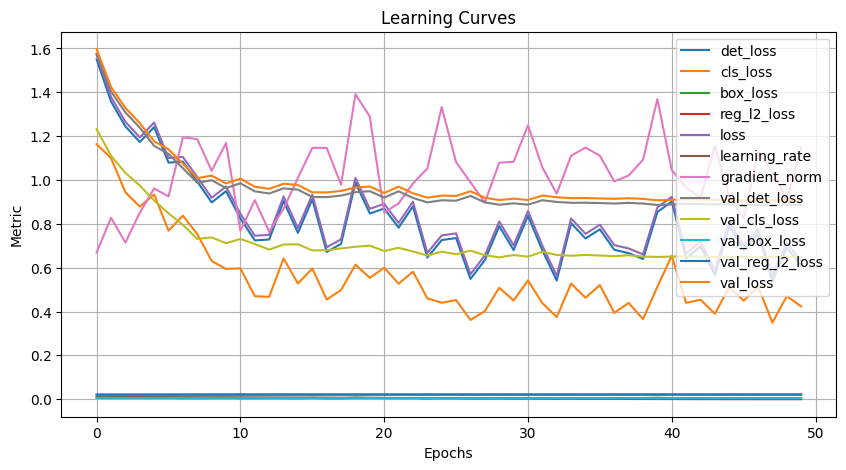

In [14]:
history = model.model.history

if history and hasattr(history, 'history'):
    plt.figure(figsize = (10, 5))
    for key, values in history.history.items():
        plt.plot(values, label=key)
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

### Model Evaluation

In [20]:
metrics = model.evaluate(val_data)

print("\nEvaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

2/2 [==============================] - 184s 62s/step


Evaluation Metrics:
AP: 0.2092
AP50: 0.3274
AP75: 0.2080
APs: 0.0331
APm: 0.2617
APl: 0.3497
ARmax1: 0.2070
ARmax10: 0.3012
ARmax100: 0.3148
ARs: 0.0655
ARm: 0.3623
ARl: 0.4696
AP_/Tom Tom: -1.0000
AP_/aeroplane: 0.4070
AP_/apple: -1.0000
AP_/backpack: 0.0181
AP_/banana: -1.0000
AP_/baseball bat: 0.2822
AP_/baseball glove: 0.0026
AP_/bear: -1.0000
AP_/bed: -1.0000
AP_/bench: 0.0930
AP_/bicycle: 0.0743
AP_/bin: 0.0000
AP_/bird: 0.9000
AP_/boat: 0.0000
AP_/book: 0.0201
AP_/bottle: 0.2020
AP_/bowl: 0.0000
AP_/broccoli: -1.0000
AP_/bus: 0.3992
AP_/cake: 0.0000
AP_/car: 0.2669
AP_/cat: 0.1338
AP_/cell phone: 0.0000
AP_/chair: 0.1145
AP_/clock: 0.0448
AP_/cng: 0.1942
AP_/cow: 0.3877
AP_/cup: 0.1065
AP_/diningtable: 0.2125
AP_/dog: 0.1306
AP_/donut: -1.0000
AP_/door: -1.0000
AP_/elephant: 0.7579
AP_/fire hydrant: 0.0786
AP_/fork: 0.0000
AP_/frisbee: 0.7566
AP_/giraffe: -1.0000
AP_/glass partition: -1.0000
AP_/handbag: 0.0181
AP_/horse: 0.

# Export TFLite (float16)

In [24]:
from tflite_model_maker.config import QuantizationConfig

model.export(
    export_dir='.',
    export_format=[ExportFormat.TFLITE],
    quantization_config=QuantizationConfig.for_float16()
)

os.rename("model.tflite", "EfficientDet_Lite2_detector_float16.tflite")